In [1]:
import numpy as np
import pydicom
import nibabel as nib
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.measurements import label

In [ ]:
studyCode='koveri0001'
files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
for i in files:
    if 'Rest' in i or 'rest' in i:
        pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])
file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[0])
ds=pydicom.dcmread(file)
print(ds)

In [3]:
#suv=r*w/a, r (Bq/ml), a' (kBq), w (kg), suv unit (g/ml)

In [3]:
def preprocessTotalSegImg(img_path):

    img=nib.load(img_path)
    img=img.get_fdata()
    img1=np.zeros((220,220,380))
    for i in range(380):
        img_i=cv2.resize(img[70:442,70:442,379-i],(220,220))
        for j in range(220):
            img1[:,j,i]=img_i[j,:]
    img1=cv2.flip(img1,0)
    img1=np.round(img1,1)
    return(img1)

def organTAC(img4d,img,indexList):

    #create another image matrix where the values within the greatest connected component of the target are 1 and the others are 0
    img1=np.zeros((img.shape))
    for j in indexList:
        img1+=np.array(img==j,dtype=int)
    TAC=np.zeros((24))
    if np.max(img1)>0:
        structure=np.ones((3,3,3),dtype=int)
        labeled, ncomponents = label(img1,structure)
        u1=[]
        for u in range(1,ncomponents+1):
            img0=np.array(labeled==u,dtype=int)
            u1.append(np.sum(img0))
        u=np.argmax(u1)+1
        img1=np.array(labeled==u,dtype=int)
        #find the smallest rectangle containing the greatest connected component of the target by studying the maximums
        k5=0
        while(np.max(img1[:,:,k5])==0):
            k5+=1
        k6=k5
        while((np.max(img1[:,:,k6])>0) & (k6<379)):
            k6+=1
        k3=0
        while(np.max(img1[:,k3,k5:k6])==0):
            k3+=1
        k4=k3
        while((np.max(img1[:,k4,k5:k6])>0) & (k4<219)):
            k4+=1
        k1=0
        while(np.max(img1[k1,k3:k4,k5:k6])==0):
            k1+=1
        k2=k1
        while((np.max(img1[k2,k3:k4,k5:k6])>0) & (k2<219)):
            k2+=1
        #find the mean value TAC
        for i in range(24):
            TAC[i]=np.sum(img4d[k1:k2,k3:k4,k5:k6,i]*img1[k1:k2,k3:k4,k5:k6])/np.sum(img1[k1:k2,k3:k4,k5:k6])
    return(TAC)

In [78]:
intervals=np.array(14*[5]+3*[10]+3*[20]+4*[30])
t=np.zeros(24)
for i in range(24):
    t[i]=np.sum(intervals[0:(i+1)])
print(t)

[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.
  80.  90. 100. 120. 140. 160. 190. 220. 250. 280.]


In [11]:
for ind in range(45,47):
    studyCode=['koveri0001','koveri0002','koveri0003','koveri0004','koveri0005','koveri0006','koveri0007','koveri0008','koveri0009',
               'koveri0010','koveri0011','koveri0012','koveri0013','koveri0014','koveri0015','koveri0016','koveri0017','koveri0018',
               'koveri0019','koveri0020','koveri0021','koveri0022','koveri0023','koveri0024','koveri0025','koveri0026','koveri0027',
               'koveri0028','koveri0029','koveri0030','koveri0031','koveri0032','koveri0033','koveri0034','koveri0035','koveri0036',
               'koveri0037','koveri0038','koveri0039','koveri0040','koveri0041','koveri0042','koveri0043','koveri0044','koveri0045',
               'koveri0046','koveri0047','koveri0048','koveri0049','koveri0050'][ind]
    w=[90,94,79,85,73,82,81,108,63,92,64,117,99,59,89,100,103,101,78,86,87,77,114,81,90,78,65,94,121,61,95,64,60,92,101,69,62,64,132,
       98,130,67,123,80,'unknown',102,93,76][ind]
    dose=[355,356,351,308,316,336,364,354,350,406,357,319,334,350,356,341,339,332,324,322,408,402,364,385,363,334,380,364,336,351,
          362,366,396,390,359,364,334,345,379,390,348,366,321,332,295,370,356,371][ind]

    files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
    for i in files:
        if 'segments.nii' in i:
            img_path='D:/koveri/Data/{}/{}'.format(studyCode,i)
        if 'Rest' in i or 'rest' in i:
            pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])

    times=[]
    locs=[]
    for i in range(len(os.listdir(pathToDcmFolder))):
        file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
        ds=pydicom.dcmread(file)
        times.append(ds.AcquisitionTime)
        locs.append(ds.SliceLocation)
    uniTimes=np.sort(np.unique(np.array(times)))
    uniLocs=np.sort(np.unique(np.array(locs)))

    img4d=np.zeros((220,220,380,24))
    for k in range(24):
        for i in range(len(os.listdir(pathToDcmFolder))):
            if times[i]==uniTimes[k]:
                file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
                ds=pydicom.dcmread(file)
                for j in range(len(uniLocs)):
                    if uniLocs[j]==locs[i]:
                        img4d[:,:,j,k]=cv2.resize(ds.pixel_array*ds[0x0028, 0x1053].value,(220,220))+ds[0x0028, 0x1052].value

    img=preprocessTotalSegImg(img_path)

    indexes=[[3],[6],[24],[41],[42],[43],[44],[45],[40],[77],[46],[38],[39],[9],[80],[17],[19],[36],[30],[70],[98]]
    array=np.zeros((21,24))
    for i in range(21):
        array[i,:]=organTAC(img4d,img,indexes[i])
        print(i)
    array=array*0.001*w/dose
    df=pd.DataFrame(array)
    df.to_csv('array_{}.csv'.format(studyCode))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


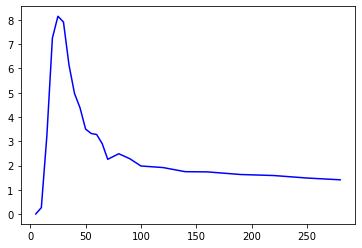

In [10]:
plt.plot(t,array[3,:],color='blue')

In [3]:
ind=13
studyCode=['koveri0001','koveri0002','koveri0003','koveri0004','koveri0005','koveri0006','koveri0007','koveri0008','koveri0009',
               'koveri0010','koveri0011','koveri0012','koveri0013','koveri0014','koveri0015','koveri0016','koveri0017','koveri0018',
               'koveri0019','koveri0020','koveri0021','koveri0022','koveri0023','koveri0024','koveri0025','koveri0026','koveri0027',
               'koveri0028','koveri0029','koveri0030','koveri0031','koveri0032','koveri0033','koveri0034','koveri0035','koveri0036',
               'koveri0037','koveri0038','koveri0039','koveri0040','koveri0041','koveri0042','koveri0043','koveri0044','koveri0045',
               'koveri0046','koveri0047','koveri0048','koveri0049','koveri0050'][ind]
w=[90,94,79,85,73,82,81,108,63,92,64,117,99,59,89,100,103,101,78,86,87,77,114,81,90,78,65,94,121,61,95,64,60,92,101,69,62,64,132,
       98,130,67,123,80,'unknown',102,93,76][ind]
dose=[355,356,351,308,316,336,364,354,350,406,357,319,334,350,356,341,339,332,324,322,408,402,364,385,363,334,380,364,336,351,
          362,366,396,390,359,364,334,345,379,390,348,366,321,332,295,370,356,371][ind]

files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
for i in files:
    if 'segments.nii' in i:
        img_path='D:/koveri/Data/{}/{}'.format(studyCode,i)
    if 'Rest' in i or 'rest' in i:
        pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])

times=[]
locs=[]
for i in range(len(os.listdir(pathToDcmFolder))):
    file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
    ds=pydicom.dcmread(file)
    times.append(ds.AcquisitionTime)
    locs.append(ds.SliceLocation)
uniTimes=np.sort(np.unique(np.array(times)))
uniLocs=np.sort(np.unique(np.array(locs)))

img4d=np.zeros((220,220,380,24))
for k in range(24):
    for i in range(len(os.listdir(pathToDcmFolder))):
        if times[i]==uniTimes[k]:
            file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
            ds=pydicom.dcmread(file)
            for j in range(len(uniLocs)):
                if uniLocs[j]==locs[i]:
                    img4d[:,:,j,k]=cv2.resize(ds.pixel_array*ds[0x0028, 0x1053].value,(220,220))+ds[0x0028, 0x1052].value

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [128]:
t[15]

90.0

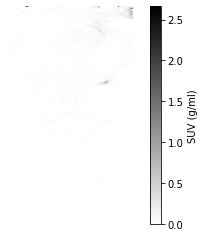

In [131]:
img=img4d[115,:,:,0]*0.001*w/dose
plt.imshow(cv2.rotate(img,cv2.cv2.ROTATE_90_CLOCKWISE),cmap='gray_r')
plt.axis('off')
plt.colorbar(label='SUV (g/ml)')
fig=plt.gcf()
#fig.savefig('fig1_90.png',bbox_inches='tight')